该算法较原算法在速度上快了17倍！

Processing s=0.800
Processing s=0.807
Processing s=0.813
Processing s=0.820
Processing s=0.827
Processing s=0.834
Processing s=0.841
Processing s=0.848
Processing s=0.855
Processing s=0.862
Processing s=0.869
Processing s=0.876
Processing s=0.884
Processing s=0.891
Processing s=0.898
Processing s=0.906
Processing s=0.913
Processing s=0.921
Processing s=0.928
Processing s=0.936
Processing s=0.944
Processing s=0.952
Processing s=0.960
Processing s=0.968
Processing s=0.976
Processing s=0.984
Processing s=0.992
Processing s=1.000
Processing s=1.009
Processing s=1.017
Processing s=1.025
Processing s=1.034
Processing s=1.043
Processing s=1.051
Processing s=1.060
Processing s=1.069
Processing s=1.078
Processing s=1.087
Processing s=1.096
Processing s=1.105
Processing s=1.114
Processing s=1.123
Processing s=1.132
Processing s=1.142
Processing s=1.151
Processing s=1.161
Processing s=1.171
Processing s=1.180
Processing s=1.190
Processing s=1.200


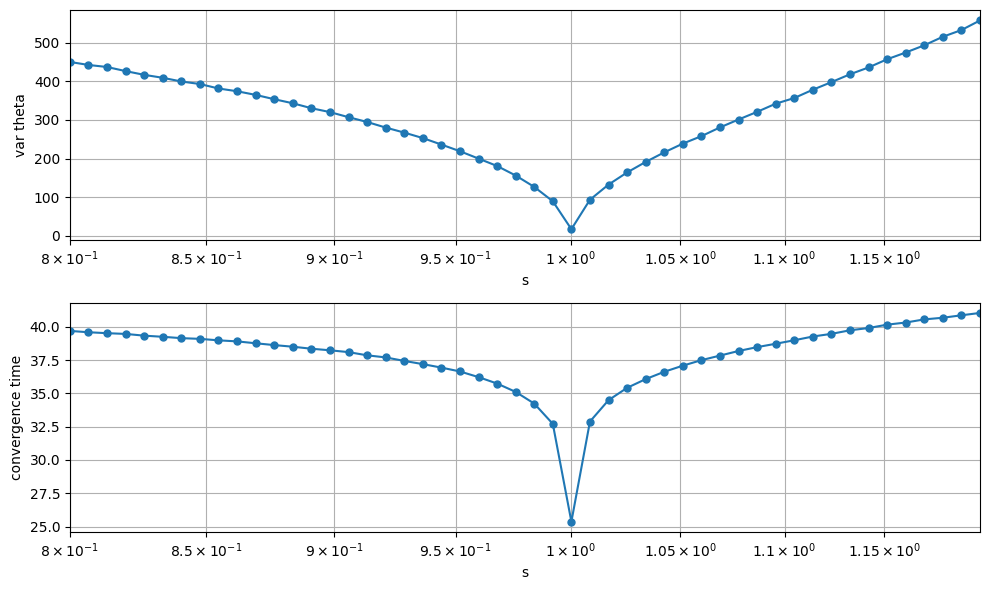

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# 固定参数
n = 200
p = 0.1
threshold = 1e-2
max_iterations = 1000
num_simulations = 10000
delta = 1
epsilon = 0.1
alpha = 1e-6

# 生成图结构
A = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        w = np.random.binomial(1, 0.1) + np.random.binomial(1, 0.1)
        A[i, j] = w
        A[j, i] = w

D = np.diag(A.sum(axis=1))
L = D - A
d_max = D.max().item()
h = 0.99 / d_max
theta0 = np.random.normal(50, 10, n)

# 单次模拟函数
def run_single_simulation(A_matrix, B, theta0, c, q, threshold, max_iterations):
    theta = theta0.copy()
    converged = False
    q_power = 1.0
    for k in range(max_iterations):
        b = c * q_power
        eta = np.random.laplace(scale=b, size=n)
        next_theta = A_matrix @ theta + B @ eta
        thres_hold = max(threshold, b * 0.1)
        if np.max(np.abs(next_theta - theta)) < thres_hold:
            converged = True
            break
        theta = next_theta  # 避免复制
        q_power *= q  # 累积乘法
    return (k if converged else max_iterations, np.mean(theta))

# 参数s的模拟
def simulate_s(s):
    q = alpha + (1 - alpha) * abs(s - 1)
    c = delta * q / (epsilon * (q - abs(s - 1)))
    S, B = s * np.eye(n), s * np.eye(n) - h * L
    A_matrix = np.eye(n) - h * L

    # 并行执行模拟
    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(run_single_simulation)(A_matrix, B, theta0, c, q, threshold, max_iterations)
        for _ in range(num_simulations)
    )
    convergence_times, theta_avgs = zip(*results)
    return np.std(theta_avgs), np.mean(convergence_times)

# 主程序
if __name__ == '__main__':
    s_values = np.logspace(np.log10(0.8), np.log10(1.2), num=50)
    variances, times = [], []

    for s in s_values:
        print(f"Processing s={s:.3f}")
        var, avg = simulate_s(s)
        variances.append(var)
        times.append(avg)
    variances = np.sqrt(np.array(variances))

    # 绘图
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.semilogx(s_values, variances, 'o-', markersize=5)
    plt.xlabel('s'); plt.ylabel('var theta')
    plt.xlim(0.8, 1.2); plt.grid(True)
    plt.xticks(np.arange(0.8, 1.2, 0.05))

    plt.subplot(2, 1, 2)
    plt.semilogx(s_values, times, 'o-', markersize=5)
    plt.xlabel('s'); plt.ylabel('convergence time')
    plt.xlim(0.8, 1.2); plt.grid(True)
    plt.xticks(np.arange(0.8, 1.2, 0.05))
    plt.tight_layout()
    plt.show()